# 🧬 Entrenamiento de modelos YOLOv8/v11 para segmentación de esferoides

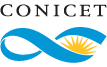

Este notebook documenta un pipeline completo y reproducible para el entrenamiento, visualización y análisis de modelos de segmentación utilizando la arquitectura **YOLOv8/v11** de **Ultralytics**, aplicada al reconocimiento de **esferoides celulares** en imágenes de microscopía.

El enfoque combina herramientas modernas de deep learning con augmentaciones específicas, análisis de métricas por época, y generación automática de informes comparativos entre modelos. Todo el flujo está orientado a la documentación científica y puede integrarse fácilmente en informes institucionales, publicaciones o repositorios públicos.

---

### 🧱 Estructura del notebook

| Bloque       | Descripción                                                                     |
| ------------ | ------------------------------------------------------------------------------- |
| **Bloque 1** | Instalación y configuración del entorno. Incluye dependencias y setup básico.   |
| **Bloque 2** | Entrenamiento automático de múltiples modelos YOLO con parámetros comunes.      |
| **Bloque 3** | Visualización de pérdidas y métricas por época para cada modelo entrenado.      |
| **Bloque 4** | Generación de un informe resumen con las métricas finales de todos los modelos. |

---

### 📌 Aplicación

El modelo entrenado puede utilizarse para:

* Segmentación automática de esferoides en experimentos de alto rendimiento.
* Evaluación morfológica y cuantificación de tamaño, forma y número.
* Apoyo al análisis automatizado en estudios de cultivos 3D, toxicidad o respuesta a tratamientos.

---

> ⚠️ Este notebook está preparado para ejecutarse tanto en entornos locales con GPU como en plataformas como **Kaggle** o **Google Colab**. Se recomienda fijar las versiones de los paquetes para garantizar reproducibilidad.


### 📦 **Bloque 1 – Instalación y setup**

En esta sección se realiza la instalación de las dependencias necesarias y la configuración básica del entorno de trabajo.

* Se instala la librería **Ultralytics** que permite utilizar modelos YOLOv8 y YOLOv11 para tareas de segmentación.
* Se importan módulos auxiliares como `os`, `yaml`, `numpy` y `pandas`, que serán utilizados para manejo de archivos, configuraciones y procesamiento de datos durante el entrenamiento.
* Se recomienda fijar explícitamente la versión del paquete (`ultralytics==x.y.z`) para asegurar la reproducibilidad de los experimentos, especialmente cuando el código forma parte de un informe o repositorio público.

Este bloque garantiza que el entorno esté preparado para la ejecución de los pasos posteriores, sin depender de configuraciones externas.



In [ ]:
# =============================================
# BLOQUE 1 – Instalación de dependencias y setup inicial
# =============================================

# Instalamos el paquete principal: Ultralytics YOLOv8
# - Esto incluye herramientas para entrenamiento, validación y exportación de modelos
# - Se sugiere fijar una versión estable para reproducibilidad (ver: https://github.com/ultralytics/ultralytics/releases)
!pip install -q ultralytics==8.0.215  # o la última versión estable usada en este notebook

# Importamos el core de YOLOv8
from ultralytics import YOLO

# Librerías auxiliares
import yaml  # Para leer y escribir archivos de configuración
import os    # Para operaciones de sistema
import numpy as np  # Álgebra lineal y arrays
import pandas as pd  # Procesamiento de datos y CSVs


### 🧠 **Bloque 2 – Entrenamiento de modelos YOLOv8/v11 con segmentación**

En este bloque se automatiza el entrenamiento de múltiples variantes del modelo YOLO (por ejemplo, `yolo11n-seg`, `yolo11s-seg`, `yolo11m-seg`), todas configuradas para tareas de **segmentación de esferoides**.

* Se define una lista de modelos preentrenados (`.pt`) que serán usados como punto de partida para el fine-tuning.
* Se configuran los **hiperparámetros comunes** a todos los entrenamientos: número de épocas, tamaño de imagen, batch size, estrategia de augmentación, paciencia para early stopping, etc.
* Se permite el uso de múltiples GPUs simultáneamente (`device: "0,1"`) si el entorno lo soporta.
* Para cada modelo:

  * Se instancia el objeto `YOLO`.
  * Se define un nombre único de experimento.
  * Se guarda un archivo de configuración `.json` con los parámetros usados, asegurando **reproducibilidad y trazabilidad**.
  * Se entrena el modelo con `model.train(...)`.

Este bloque genera automáticamente una carpeta con los resultados por modelo dentro del directorio `runs/segment/`, incluyendo métricas, logs y pesos entrenados.



In [ ]:
# =============================================
# BLOQUE 2 – Entrenamiento de modelos YOLOv8-Seg para esferoides
# =============================================

from ultralytics import YOLO
import os
import json
from pathlib import Path

# Lista de modelos base a entrenar
modelos = [
    'yolo11n-seg.pt',
    'yolo11s-seg.pt',
    'yolo11m-seg.pt'
]

# Ruta al archivo data.yaml (dataset anotado para segmentación)
data_yaml_path = Path('data/data.yaml')
assert data_yaml_path.exists(), f"[ERROR] No se encontró el archivo {data_yaml_path}"

# Directorio base donde guardar los resultados
output_dir = Path('runs')
output_dir.mkdir(parents=True, exist_ok=True)

# Parámetros comunes para todos los entrenamientos
train_kwargs_base = {
    'data': str(data_yaml_path),
    'epochs': 50,
    'imgsz': 320,
    'batch': 16,
    'device': '0,1',
    'patience': 10,
    'project': str(output_dir),
    'save': True,
    'plots': True,
    'val': True,
    'warmup_epochs': 2,
    'cache': 'ram',
    # Augmentations
    'degrees': 15,
    'shear': 10,
    'translate': 0.1,
    'scale': 0.5,
    'flipud': 0.2,
    'fliplr': 0.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'mosaic': 1.0,
    'mixup': 0.2,
    'copy_paste': 0.1
}

# Entrenamiento por cada modelo
for modelo in modelos:
    model_path = Path(modelo)
    assert model_path.exists(), f"[ERROR] El modelo base '{modelo}' no fue encontrado en el entorno."

    print(f"\n🚀 Entrenando modelo: {modelo}")
    try:
        model = YOLO(modelo)
    except Exception as e:
        print(f"[ERROR] Falló la carga del modelo {modelo}: {e}")
        continue

    # Nombre base del experimento
    model_name = model_path.stem.replace('-', '_')
    exp_name = f'{model_name}_spheroids_320'
    
    # Copiar parámetros y agregar nombre de experimento
    train_kwargs = train_kwargs_base.copy()
    train_kwargs['name'] = exp_name

    # Guardar configuración del experimento
    config_path = output_dir / f'{exp_name}_config.json'
    with open(config_path, 'w') as f:
        json.dump(train_kwargs, f, indent=4)
    
    print(f"[INFO] Entrenando: {exp_name}")
    try:
        model.train(**train_kwargs)
    except Exception as e:
        print(f"[ERROR] Falló el entrenamiento de {modelo}: {e}")


### 📊 **Bloque 3 – Visualización de métricas de entrenamiento**

Este bloque permite inspeccionar gráficamente el desempeño de cada modelo durante el entrenamiento.

* Se define la función `graficar_metricas_entrenamiento()`, que recibe como entrada la carpeta del experimento (`runs/segment/...`) y genera gráficos automáticos de:

  * **Pérdidas** (box loss y segmentation loss en entrenamiento y validación).
  * **Métricas de evaluación** (precision, recall, mAP\@50 y mAP\@50-95).
* Los gráficos se muestran por pantalla y también se pueden guardar como archivos `.png` en la misma carpeta del experimento.
* Se incorporan controles de errores: la función valida que el archivo `results.csv` exista y maneja faltantes de columnas de manera robusta.
* Opcionalmente, la función puede devolver el DataFrame con los resultados por época para facilitar análisis adicionales.

Este bloque facilita la **evaluación visual** de la convergencia y el rendimiento de los modelos, ayudando a detectar problemas como sobreajuste, poca mejora, o augmentations excesivos.



In [ ]:
# =============================================
# BLOQUE 3 – Visualización de métricas de entrenamiento YOLO
# =============================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_metricas_entrenamiento(folder_path, save_plots=True, return_df=False):
    """
    Carga los resultados de entrenamiento de YOLOv8/v11 y genera gráficos de métricas.

    Parámetros:
    - folder_path (str): ruta a la carpeta del experimento (debe contener results.csv).
    - save_plots (bool): si True, guarda los PNGs de los gráficos.
    - return_df (bool): si True, devuelve el DataFrame con resultados.

    Retorna:
    - df (pd.DataFrame): resultados si return_df=True; None si False.
    """

    if not os.path.isdir(folder_path):
        print(f"❌ La carpeta no existe: {folder_path}")
        return None

    csv_path = os.path.join(folder_path, "results.csv")
    if not os.path.isfile(csv_path):
        print(f"❌ No se encontró el archivo 'results.csv' en: {folder_path}")
        return None

    # Leer el CSV
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # 🔹 Gráfico de pérdidas
    plt.figure(figsize=(10, 6))
    hay_perdidas = False

    if "train/box_loss" in df:
        plt.plot(df["epoch"], df["train/box_loss"], label="Box loss (train)")
        hay_perdidas = True
    if "val/box_loss" in df:
        plt.plot(df["epoch"], df["val/box_loss"], label="Box loss (val)")
        hay_perdidas = True
    if "train/seg_loss" in df:
        plt.plot(df["epoch"], df["train/seg_loss"], label="Seg loss (train)")
        hay_perdidas = True
    if "val/seg_loss" in df:
        plt.plot(df["epoch"], df["val/seg_loss"], label="Seg loss (val)")
        hay_perdidas = True

    if hay_perdidas:
        plt.title("Curva de pérdidas por época", fontsize=14)
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        if save_plots:
            plt.savefig(os.path.join(folder_path, "losses.png"), dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print("⚠️ No se encontraron columnas de pérdida para graficar.")

    # 🔹 Gráfico de métricas
    metricas = {
        "metrics/precision(M)": "Precision",
        "metrics/recall(M)": "Recall",
        "metrics/mAP50(M)": "mAP50",
        "metrics/mAP50-95(M)": "mAP50-95"
    }

    plt.figure(figsize=(10, 6))
    hay_metricas = False
    for col, label in metricas.items():
        if col in df.columns:
            plt.plot(df["epoch"], df[col], label=label)
            hay_metricas = True

    if hay_metricas:
        plt.title("Métricas de evaluación por época", fontsize=14)
        plt.xlabel("Época")
        plt.ylabel("Valor")
        plt.ylim(0, 1.05)
        plt.legend()
        plt.grid(True)
        if save_plots:
            plt.savefig(os.path.join(folder_path, "metrics.png"), dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print("⚠️ No se encontraron columnas de métricas para graficar.")

    print(f"✅ Gráficos generados para: {folder_path}")
    return df if return_df else None


In [ ]:
for modelo in modelos:
    exp_name = modelo.replace(".pt", "").replace("-", "_") + "_spheroids_320"
    path_exp = f"runs/segment/{exp_name}"
    graficar_metricas_entrenamiento(path_exp)


### 📑 **Bloque 4 – Informe automatizado de entrenamientos**

Este bloque genera un **resumen cuantitativo** de todos los modelos entrenados, consolidando sus métricas principales en una única tabla.

* Se define la función `generar_informe_entrenamientos()` que:

  * Recorre todas las carpetas de entrenamiento generadas por YOLO (`runs/segment/...`).
  * Extrae los valores finales de cada métrica desde el archivo `results.csv`:

    * `mAP50`, `mAP50-95`, `precision`, `recall`, `val/box_loss`, `val/seg_loss`.
  * Crea un DataFrame resumen con una fila por modelo entrenado.
  * Guarda automáticamente el resultado como archivo `.csv` o `.xlsx`.

* Esta tabla permite:

  * Comparar modelos fácilmente.
  * Identificar el mejor modelo según la métrica deseada.
  * Documentar los resultados de forma clara para informes técnicos o publicaciones.

El informe es reproducible y puede extenderse fácilmente para incluir tiempos de entrenamiento, hiperparámetros clave, o rendimiento en datos externos.


In [ ]:
# =============================================
# BLOQUE 4 – Informe automatizado de entrenamientos YOLO
# =============================================

import os
import pandas as pd
from pathlib import Path

def generar_informe_entrenamientos(root_runs_dir, modelo_list=None, save_path=None):
    """
    Recorre las carpetas de entrenamiento y genera un resumen por modelo.

    Parámetros:
    - root_runs_dir (str): Ruta al directorio base (ej: "runs/segment/")
    - modelo_list (list): Lista de nombres de modelo (carpetas dentro de root_runs_dir)
                          Si es None, se usa todo lo que haya en el directorio.
    - save_path (str): Ruta para guardar el CSV generado (si es None, lo guarda en root_runs_dir)

    Retorna:
    - df_resultados (pd.DataFrame): Tabla resumen con las métricas principales.
    """
    root = Path(root_runs_dir)
    assert root.exists(), f"[ERROR] No existe la carpeta {root_runs_dir}"

    if modelo_list is None:
        modelo_list = [f.name for f in root.iterdir() if f.is_dir()]

    resultados = []

    for modelo in modelo_list:
        results_csv = root / modelo / "results.csv"
        if not results_csv.exists():
            print(f"⚠️ No se encontró results.csv para el modelo {modelo}")
            continue

        df = pd.read_csv(results_csv)
        last_row = df.iloc[-1]  # Última época

        datos = {
            "Modelo": modelo,
            "Epoch final": int(last_row.get("epoch", len(df)-1)),
            "mAP50": round(last_row.get("metrics/mAP50(M)", 0.0), 4),
            "mAP50-95": round(last_row.get("metrics/mAP50-95(M)", 0.0), 4),
            "Precision": round(last_row.get("metrics/precision(M)", 0.0), 4),
            "Recall": round(last_row.get("metrics/recall(M)", 0.0), 4),
            "Box Loss (val)": round(last_row.get("val/box_loss", 0.0), 4),
            "Seg Loss (val)": round(last_row.get("val/seg_loss", 0.0), 4)
        }

        resultados.append(datos)

    df_resultados = pd.DataFrame(resultados)

    if save_path is None:
        save_path = root / "informe_resumen_entrenamientos.csv"
    else:
        save_path = Path(save_path)

    df_resultados.to_csv(save_path, index=False)
    print(f"✅ Informe guardado en: {save_path}")

    return df_resultados


In [ ]:
# Generar resumen desde las carpetas creadas por YOLO
resumen = generar_informe_entrenamientos(
    root_runs_dir="runs/segment"
)

# Mostrar el top 3 modelos por mAP50
resumen.sort_values("mAP50", ascending=False).head(3)


### 🤖 Nota sobre el uso de modelos de lenguaje

Algunas secciones de este notebook —incluyendo partes del código, documentación y redacción técnica— fueron generadas o asistidas mediante el uso de modelos de lenguaje de gran escala (LLMs), con el objetivo de:

* Mejorar la claridad y estructura de la documentación.
* Acelerar la redacción de funciones repetitivas o genéricas.
* Incorporar buenas prácticas de reproducibilidad y robustez en el código.

Todas las decisiones científicas, técnicas y metodológicas fueron supervisadas y validadas por el autor responsable. El uso de herramientas de IA se integró como un recurso de apoyo para la productividad, manteniendo el control conceptual y experimental del trabajo.